# Quantum_Magnetometer Federal

In [1]:
from pathlib import Path
import sys, site, os, glob, re, pathlib, warnings, logging
from types import SimpleNamespace

print("Python:", sys.executable)
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX"))

env = os.environ.get("CONDA_PREFIX") or sys.prefix

env_bin = os.path.join(env, "Library", "bin")
os.environ["PATH"] = os.pathsep.join([env_bin, os.environ.get("PATH", "")])



for k in ["XLA_FLAGS", "TF_XLA_FLAGS", "TF_XLA_ENABLE_XLA_DEVICES"]:
    if k in os.environ:
        del os.environ[k]

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs visible:", tf.config.list_physical_devices("GPU"))


# Enable memory growth to avoid full-GPU preallocation
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("set_memory_growth failed:", e)

# Expose project root so src.qsensoropt is a package
PROJECT_ROOT = Path("C:/Users/tvle2/Documents/Code/MagNav/Federated RL-training/Train-RL-Federal").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Remove the bare /src dir if present (it masks the package)
bad = str(PROJECT_ROOT / "src")
if bad in sys.path:
    sys.path.remove(bad)
# Expose examples/ so nv_center_dc.py can be imported
EXAMPLES = PROJECT_ROOT / "examples"
if str(EXAMPLES) not in sys.path:
    sys.path.append(str(EXAMPLES))


from typing import List, Optional, Tuple, Literal
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import builtins, inspect

from tensorflow import Tensor, concat, constant, float32, __version__, config
from tensorflow.math import exp, cos, abs as tf_abs
from tensorflow.random import uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow import convert_to_tensor, cast, constant
from tensorflow.math import divide, add, sqrt
from tensorflow.random import uniform as tf_uniform

from numpy import ceil, sqrt

# qsensoropt package
import src.qsensoropt.utils as qutils
from src.qsensoropt import InverseSqrtDecay, ParticleFilter, Parameter, SimulationParameters
from src.qsensoropt.utils import train, standard_model


from nv_center_dc import NVCenter, Magnetometry



Python: c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\python.exe
CONDA_PREFIX: C:\Users\tvle2\AppData\Local\anaconda3\envs\localizing
TF: 2.10.1
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Patches

In [2]:
# ---------- PATCH A · save_weights always ends with .weights.h5 --------------
if not getattr(tf.keras.Model.save_weights, "_patched", False):        # ← NEW
    _real_save = tf.keras.Model.save_weights

    def _safe_save(self, fn, *a, **k):
        fn = str(fn)
        if not fn.endswith(".weights.h5"):
            fn += ".weights.h5"
        Path(fn).parent.mkdir(parents=True, exist_ok=True)
        return _real_save(self, fn, *a, **k)

    _safe_save._patched = True                                          # ← NEW
    tf.keras.Model.save_weights = _safe_save

# ----- load_weights wrapper (NEW guard) --------------------------------------
if not getattr(tf.keras.Model.load_weights, "_patched", False):
    _real_load = tf.keras.Model.load_weights            # <-- keep original

    def _safe_load(self, filepath, *args, **kw):
        fp = str(filepath)

        # 1) ensure recognised suffix
        if not (fp.endswith(".weights.h5") or fp.endswith(".keras") or fp.endswith(".h5")):
            fp += ".weights.h5"

        # 2) try "<iter>_<head>.weights.h5" fallback
        if not Path(fp).exists():
            m = re.search(r"(\d+)(\d)\.weights\.h5$", fp)
            if m:
                fp_alt = re.sub(r"(\d+)(\d)\.weights\.h5$", r"\1_\2.weights.h5", fp)
                if Path(fp_alt).exists():
                    fp = fp_alt

        return _real_load(self, fp, *args, **kw)

    _safe_load._patched = True
    tf.keras.Model.load_weights = _safe_load

if not getattr(tf.keras.Model.save, "_patched", False):
    _real_model_save = tf.keras.Model.save          # <‑ original method

    def _safe_model_save(self, filepath, *args, **kw):
        """
        • Forces a recognised suffix (.keras / .h5 / .weights.h5).
        • Creates parent directories if they don’t exist.
        • Delegates to the original `Model.save` exactly once.
        """
        fp = str(filepath)
        recognised = (fp.endswith(".keras") or
                      fp.endswith(".h5") or
                      fp.endswith(".weights.h5"))
        if not recognised:
            fp += ".keras"                          # default format

        pathlib.Path(fp).parent.mkdir(parents=True, exist_ok=True)
        return _real_model_save(self, fp, *args, **kw)

    _safe_model_save._patched = True                # mark as patched
    tf.keras.Model.save = _safe_model_save

## Federal: Train the federated RL agent for the proposed federated reinforcement learning algorithm

In [3]:
T2_INV = 1/1500
F0, F1 = 0.88, 0.95

class NVCenterDCMagnPhase(NVCenter):
    def __init__(
        self,
        batchsize: int,
        params: List[Parameter],
        prec: Literal["float64","float32"] = "float64",   
        res:  Literal["meas","time"]      = "meas",       
        invT2: Optional[float]            = None,         
        F0:    float                      = 1.0,          
        F1:    float                      = 1.0,          
    ):
        super().__init__(batchsize, params, prec=prec, res=res, control_phase=True)
        self.invT2 = invT2
        self.F0, self.F1 = F0, F1

    def model(self, idxN, outcomes, controls, parameters, meas_step, num_systems=1):
        τ = controls[:,:,0]
        φ = controls[:,:,1]
        ω = parameters[:,:,0]
        invT2_loc = (self.invT2 if self.invT2 is not None else parameters[:,:,1])
        decay = tf.exp(-τ * invT2_loc)

        # ±1 measurement: +1↔μ=0,  −1↔μ=1（与原码相同）
        r = outcomes[:,:,0]

        # Paper-style readout fidelity (p0)
        bias     = 0.5*(1 + self.F0 - self.F1)
        contrast = 0.5*(self.F0 + self.F1 - 1)
        p0_fid   = bias + contrast * decay * tf.cos(ω * τ + φ)

        # Returns the probability of being consistent with the observation (same "conditional" writing as the original code)
        return tf.where(r > 0, p0_fid, 1.0 - p0_fid)


def static_field_estimation(
    batchsize: int            = 1024,                 
    max_res:   int            = 10000,                
    learning_rate: float      = 1e-3,                 
    n_hidden:   int           = 64,                   
    num_particles: int        = 240,                  
    iterations:  int          = 4096,                 
    res: Literal["meas","time"]= "time",              
    invT2: Optional[float]    = T2_INV,               
    invT2_bound: Optional[Tuple[float,float]] = None, 
    omega_bounds: Tuple[float,float] = (0.0, 10.0),   
    trained_models_dir: Path  = Path("./trained_models"),
):
    """Train a federated RL controller"""

    trained_models_dir.mkdir(parents=True, exist_ok=True)
    (trained_models_dir.parent / (trained_models_dir.name + "_history_weights")).mkdir(exist_ok=True)
    print("CUDA:", tf.config.list_physical_devices("GPU"))

    # Input/output dimensions
    d = 1 if invT2 is not None else 2
    INPUT_SIZE = d**2 + 2*d + 2
    CTRL_SIZE  = 2
    NUM_HEADS  = 10

    # --- Warm-up---
    seed_net = standard_model(INPUT_SIZE, CTRL_SIZE, n_hidden, prec="float32")
    X0 = tf_uniform((16_384, INPUT_SIZE), -1.0, 1.0, dtype=tf.float32)
    tau_norm = (X0[:, -1:] + 1.0) / 2.0                       # [0,1]（与原码相同）
    phi_norm = tf_uniform((16_384, 1), -1.0, 1.0, dtype=tf.float32)
    Y0 = tf.concat([tau_norm, phi_norm], axis=1)
    seed_net.compile(loss="mse", optimizer="adam")
    seed_net.fit(X0, Y0, epochs=12, batch_size=1024, verbose=0)

    # --- 10 heads, sharing the same instance ---
    network  = seed_net
    networks = [network] * NUM_HEADS

    lr_sched  = InverseSqrtDecay(learning_rate, "float32")
    optimizer = tf.keras.optimizers.Adam(lr_sched)

    # --- physical objective ---
    pars = ([Parameter(omega_bounds, name="omega")] if invT2 is not None else
            [Parameter(omega_bounds, "omega"), Parameter(invT2_bound, "invT2")])

    nv = NVCenterDCMagnPhase(batchsize, pars,
                             prec="float32", res=res,
                             invT2=invT2,
                             F0=F0, F1=F1)            

    pf   = ParticleFilter(num_particles, nv, prec="float32")
    simp = SimulationParameters("fedrl", max_res, max_res,
                                prec="float32",
                                cumulative_loss=True,   
                                log_loss=True)         

    # --- τ's prefactor） ---
    prefact = (max_res / 20.0) if (res == "time") else float(ceil(2.0 ** sqrt(max_res)))
    invT2_min = invT2 if invT2 is not None else (invT2_bound[0] if invT2_bound is not None else None)
    if invT2_min is not None and invT2_min > 0.0:
        prefact = min(prefact, 1.0 / invT2_min)       

    def control_nn(idxN: tf.Tensor, x: tf.Tensor):
        idxN = tf.cast(idxN, tf.int32)
        pi = tf.constant(np.pi, dtype=tf.float32)

        def branch(i: int):
            y = networks[i](x)                         # tanh output ∈[-1,1]^2
            tau = tf.constant(prefact, tf.float32) * tf.abs(y[:, :1]) + 1.0
            phi = pi * y[:, 1:2]
            return lambda: tf.concat([tau, phi], axis=1)

        return tf.switch_case(idxN, {i: branch(i) for i in range(NUM_HEADS)})

    # --- simulator ---
    sim = Magnetometry(
        particle_filter=pf,
        simpars=simp,
        phys_model=nv,
        control_strategy=control_nn,
        eta_flag=(res == "time"),      # res must set like this
    )

    train(sim, optimizer, iterations, str(trained_models_dir),
          networks=networks,
          gradient_accumulation=1,
          xla_compile=False,
          interval_save=1)

In [4]:
FEDERAL_ROOT = Path("/blue/iruchkin/yuyangzhang/MagNavRL") / "Federal"
FEDERAL_ROOT.mkdir(parents=True, exist_ok=True)
MODELS_DIR = FEDERAL_ROOT / "trained_models"

static_field_estimation(
    batchsize        = 1024,
    max_res          = 10000,
    learning_rate    = 1e-3,
    invT2            = T2_INV,        # 1/1500
    trained_models_dir = MODELS_DIR,
)

CUDA: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


  0% (0 of 4096) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


0 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)


UnknownError: Graph execution error:

Detected at node 'main_loop/sub_11' defined at (most recent call last):
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\nest_asyncio.py", line 133, in _run_once
      handle._run()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tvle2\AppData\Local\Temp\ipykernel_4064\3796927226.py", line 5, in <module>
      static_field_estimation(
    File "C:\Users\tvle2\AppData\Local\Temp\ipykernel_4064\2756065478.py", line 121, in static_field_estimation
      train(sim, optimizer, iterations, str(trained_models_dir),
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 378, in train
      loss = update_nn(rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 352, in update_nn
      grads, loss = single_iteration(idxN,rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 332, in _single_iteration
      loss_diff, loss = simulation.execute(idxN,rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 1075, in execute
      # Measurement loop
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 1075, in execute
      # Measurement loop
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 559, in _loop_body
      # Measurement on the probe
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\stateless_phys_model.py", line 136, in wrapper_perform_measurement
      outcomes, log_prob = self.perform_measurement(idxN,
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\examples\nv_center_dc.py", line 78, in perform_measurement
      outcomes = 2*cast((stateless_uniform((self.bs, 1),
Node: 'main_loop/sub_11'
Detected at node 'main_loop/sub_11' defined at (most recent call last):
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\nest_asyncio.py", line 133, in _run_once
      handle._run()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\tvle2\AppData\Local\anaconda3\envs\localizing\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tvle2\AppData\Local\Temp\ipykernel_4064\3796927226.py", line 5, in <module>
      static_field_estimation(
    File "C:\Users\tvle2\AppData\Local\Temp\ipykernel_4064\2756065478.py", line 121, in static_field_estimation
      train(sim, optimizer, iterations, str(trained_models_dir),
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 378, in train
      loss = update_nn(rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 352, in update_nn
      grads, loss = single_iteration(idxN,rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\utils.py", line 332, in _single_iteration
      loss_diff, loss = simulation.execute(idxN,rangen)
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 1075, in execute
      # Measurement loop
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 1075, in execute
      # Measurement loop
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\simulation.py", line 559, in _loop_body
      # Measurement on the probe
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\src\qsensoropt\stateless_phys_model.py", line 136, in wrapper_perform_measurement
      outcomes, log_prob = self.perform_measurement(idxN,
    File "C:\Users\tvle2\Documents\Code\MagNav\Federated RL-training\Train-RL-Federal\examples\nv_center_dc.py", line 78, in perform_measurement
      outcomes = 2*cast((stateless_uniform((self.bs, 1),
Node: 'main_loop/sub_11'
2 root error(s) found.
  (0) UNKNOWN:  JIT compilation failed.
	 [[{{node main_loop/sub_11}}]]
	 [[mul_4/_42]]
  (1) UNKNOWN:  JIT compilation failed.
	 [[{{node main_loop/sub_11}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference__single_iteration_12498]

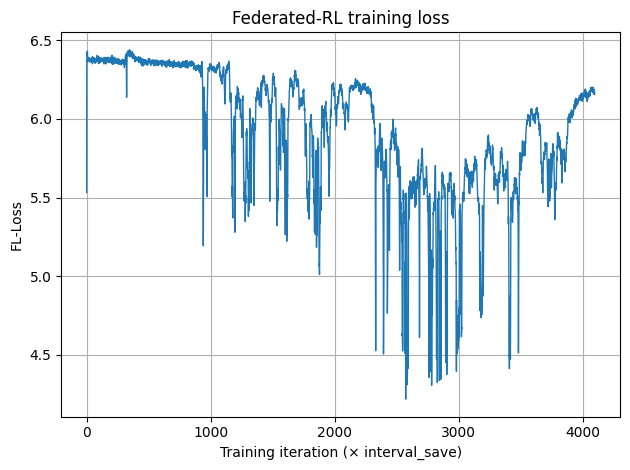

In [ ]:
# --- path to the history CSV produced by `static_field_estimation` ------------
FEDERAL_ROOT = Path("./") / "Federal"
MODELS_DIR   = FEDERAL_ROOT / "trained_models"
history_csv  = MODELS_DIR.with_name(MODELS_DIR.name + "_history.csv")  # same rule as in utils.py

# read the file
df = pd.read_csv(history_csv)

# build the x–axis: every row is one optimizer step (after averaging inside utils)
iterations = range(1, len(df) + 1)

# plot
plt.figure()
plt.plot(iterations, df["Loss"], linewidth=1)
plt.xlabel("Training iteration (× interval_save)")
plt.ylabel("FL‑Loss")
plt.title("Federated‑RL training loss")
plt.grid(True)
plt.tight_layout()
plt.show()